In [13]:
!pip install pymorphy2

In [14]:
!pip install stop_words

In [15]:
import re
import string
import pandas as pd
import pymorphy2
from stop_words import get_stop_words 
import numpy as np

In [16]:
df = pd.read_excel('sample_data/Incidents.xlsx')

In [17]:
df['Контент'].head(10).reset_index()

,index,Контент
0,0,'Добрый день! Очень надеемся на Вашу помощь в ...
1,1,"'А вот сейчас проверим, есть ли обратная связь..."
2,2,'Добрый день. Очень беспокоит ввод фиолетовой ...
3,3,"'Весь вопрос до сих пор в уборках улиц, особен..."
4,4,'Жители 1-ых этажей в жилых домах недовольны т...
5,5,"'Александр Дмитриевич, помогите построить школ..."
6,6,"'Александр Дмитриевич, городу нужна сеть велод..."
7,7,"'Александр Дмитриевич, обратите внимание, пожа..."
8,8,'У нас тоже крик души по поводу в уборках улиц...
9,9,'Купчино не убирают.'


Обработка данных

In [18]:
len(df['Тема'].unique())

61

In [19]:
df2 = pd.Series(df['Тема'].unique()).reset_index()
df2.columns = ['index_subject','Тема']
df2

,index_subject,Тема
0,0,Строительство
1,1,"Организация парковок, переходов, светофором и ..."
2,2,Прочее
3,3,Несоблюдение правил уборки проезжей части
4,4,Проблемы с благоустройством и уборкой дворов
...,...,...
56,56,Нарушение законодательства о животном мире
57,57,Туризм
58,58,Эксплуатация аттракционов
59,59,"Выбросы вредных веществ с территории предприятий,"


In [20]:
df = df.merge(df2, on='Тема')  

In [21]:
df.head()

,ID,Номер,Дата создания инцидента,Дата окончания,Категория,Локация,Регион,Приоритет,Тема,Группа темы IV,Группа темы III,Группа темы II,Группа темы I,Текущий шаг,Автор,Хост,URL поста,URL блога,Дата публикации,Подписчики,Название блога,Контент,Причина закрытия,Соблюдение SLA,Дата первого ответа,Время до ответа,Дата ответа,Пользователь,Текст ответа,Дата ответа.1,Пользователь.1,Текст ответа.1,Дата ответа.2,Пользователь.2,Текст ответа.2,Дата ответа.3,Пользователь.3,Текст ответа.3,Дата ответа.4,Пользователь.4,...,Дата ответа.87,Пользователь.87,Текст ответа.87,Дата ответа.88,Пользователь.88,Текст ответа.88,Дата ответа.89,Пользователь.89,Текст ответа.89,Дата ответа.90,Пользователь.90,Текст ответа.90,Дата ответа.91,Пользователь.91,Текст ответа.91,Дата ответа.92,Пользователь.92,Текст ответа.92,Дата ответа.93,Пользователь.93,Текст ответа.93,Дата ответа.94,Пользователь.94,Текст ответа.94,Дата ответа.95,Пользователь.95,Текст ответа.95,Дата ответа.96,Пользователь.96,Текст ответа.96,Дата ответа.97,Пользователь.97,Текст ответа.97,Дата ответа.98,Пользователь.98,Текст ответа.98,Дата ответа.99,Пользователь.99,Текст ответа.99,index_subject
0,1791600,15025,2019-03-11 15:35:39.689,2019-04-11 13:16:44.506,Жалоба,Санкт-Петербург,NaN,Высокая,Строительство,NaN,NaN,NaN,Строительство,Готово,'Алексей Демкин',ВКонтакте,http://vk.com/wall535438957_4?w=wall535438957_...,http://vk.com/id535438957,2019-03-11 15:09:40,0.0,Александр Беглов,'Добрый день! Очень надеемся на Вашу помощь в ...,Нет ответа от автора,Нет,2019-03-14 11:01:02.136,4045.0,2019-03-11 15:41:30.000,'Настя Молыгина','Уважаемый Александ Дмитриевич!<br>Очень прошу...,2019-03-11 16:48:02.000,'Алексей Демкин',"'[id7158733|Светлана], тогда эта куча будет на...",2019-03-11 17:05:45,'Алексей Демкин',"'[id126532956|Виталий], она называется ""вконта...",2019-03-11 17:22:08,'Алексей Демкин',"'[id241855683|Тамара], вас огорчает, что где-т...",2019-03-11 17:28:22.000,'Алексей Демкин',...,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,0
1,1792392,15064,2019-03-11 16:28:08.493,2019-04-11 13:52:35.556,Жалоба,Санкт-Петербург,NaN,Высокая,Строительство,NaN,NaN,NaN,Строительство,Готово,'Женя Орлов',ВКонтакте,http://vk.com/wall535438957_4?w=wall535438957_...,http://vk.com/id535438957,2019-03-11 15:23:47,0.0,Александр Беглов,"'Александр Дмитриевич, помогите построить школ...",Автор нейтрален,Да,2019-03-12 17:37:04.092,1508.0,2019-03-11 15:23:51.000,'Ольга Цветкова',"'Добрый день. Подскажите, пожалуйста, когда ре...",2019-03-12 17:37:04.092,'Шмыглевская Юлия Вадимовна','{получатели}Добрый день! В Пушкинском районе ...,2019-03-13 20:04:20,'Женя Орлов','Помогите построить школу в посёлке Ленсоветов...,2019-03-13 20:04:20,'Женя Орлов','Помогите построить школу в посёлке Ленсоветов...,2019-03-13 21:06:45.310,'test test05',...,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,0
2,1799935,15338,2019-03-12 13:21:47.849,2019-04-11 12:19:56.806,Жалоба,Санкт-Петербург,NaN,Высокая,Строительство,NaN,NaN,NaN,Строительство,Готово,'Татьяна Предтеченская',ВКонтакте,http://vk.com/wall535438957_4?w=wall535438957_...,http://vk.com/id535438957,2019-03-11 23:02:25,0.0,Александр Беглов,'!!!МЕТРО!!! Услышьте Питер!!! В Москве каждый...,Автор недоволен,Да,2019-03-13 16:25:46.558,1623.0,2019-03-13 16:25:46.558,'Боженкова Ольга Викторовна','[id176957|Татьяна Предтеченская] Добрый день!...,2019-03-13 18:04:39.000,'Татьяна Предтеченская','[club176831236|Комитет по развитию транспортн...,2019-03-13 18:08:53,'Татьяна Предтеченская','[club126217409|Администрация Кировского район...,NaT,NaN,NaN,NaT,NaN,...,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,0
3,1800941,15438,2019-03-12 14:35:09.749,2019-04-11 14:08:30.219,Жалоба,Санкт

In [22]:
#вычисление target label (выходных меток для обучения)
#61 класс
labels = np.array(df['index_subject'])

In [23]:
sw = set(get_stop_words("ru"))
stpwrds = list(sw) + list(string.punctuation)

In [24]:
morph = pymorphy2.MorphAnalyzer()

In [25]:
corpus = []
# регулярка для поиска слов
regular_expr = r'\w+'
reg_expr_compiled = re.compile(regular_expr)

for raw_text in df['Контент'].values:
    # приводим к нижнему регистру
    # разбиваем текст на слова
    text_by_words = reg_expr_compiled.findall(raw_text)
    raw_text = [i for i in text_by_words if i not in stpwrds]
    raw_text_lower = [morph.parse(i.lower())[0].normal_form for i in raw_text]
    corpus.append(" ".join([i for i in raw_text_lower]))
print(corpus[1])

александр дмитриевич помочь построить школа посёлок ленсоветовский пушкинский район население один ребёнок инфраструктура хватать школа учиться 2 смена


In [26]:
texts = corpus
len(texts)

10607

Конструирование нейронной сети

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical 

In [28]:
maxlen = 400
training_samples = 7000
validation_samples = 3607
max_words = 10000
drop_embed = 0.2
n_conv = 256
k_conv = 3 

In [29]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [30]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 32640 unique tokens.


In [31]:
data = pad_sequences(sequences, maxlen=maxlen)

In [32]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (10607, 400)
Shape of label tensor: (10607,)


In [33]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [34]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [35]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [36]:
embedding_dim = 100#64

In [62]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from sklearn.metrics import roc_auc_score, roc_curve
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(drop_embed))

model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(61, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 400, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 400, 100)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 398, 256)          77056     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 61)                15677     
Total params: 1,092,733
Trainable params: 1,092,733
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer='rmsprop', 
             loss='categorical_crossentropy',
             metrics=['acc'])

In [64]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
219/219 [==============================] - 4s 15ms/step - loss: 3.4731 - acc: 0.1561 - val_loss: 3.0135 - val_acc: 0.2509
Epoch 2/10
219/219 [==============================] - 3s 14ms/step - loss: 2.8758 - acc: 0.2731 - val_loss: 2.5923 - val_acc: 0.3488
Epoch 3/10
219/219 [==============================] - 3s 14ms/step - loss: 2.4726 - acc: 0.3649 - val_loss: 2.4172 - val_acc: 0.3798
Epoch 4/10
219/219 [==============================] - 3s 14ms/step - loss: 2.2141 - acc: 0.4247 - val_loss: 2.2746 - val_acc: 0.4195
Epoch 5/10
219/219 [==============================] - 3s 14ms/step - loss: 1.9778 - acc: 0.4836 - val_loss: 2.1853 - val_acc: 0.4242
Epoch 6/10
219/219 [==============================] - 3s 14ms/step - loss: 1.7389 - acc: 0.5499 - val_loss: 2.1380 - val_acc: 0.4383
Epoch 7/10
219/219 [==============================] - 3s 14ms/step - loss: 1.4986 - acc: 0.6175 - val_loss: 2.1016 - val_acc: 0.4488
Epoch 8/10
219/219 [==============================] - 3s 14ms/step - 

In [65]:
import matplotlib.pyplot as plt 

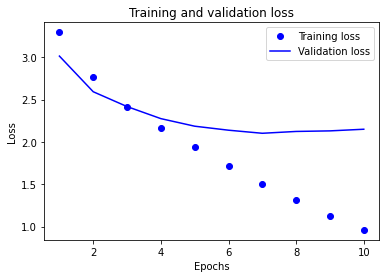

In [66]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

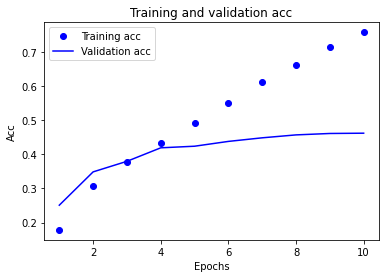

In [67]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

Вывод: в случае случайного выбора темы точность случайного классификатора была бы 1/60 (всего 61 класс). Получившаяся точность - 0.3. Это в 20 раз лучше случайного.  

In [68]:
y_hat = model.predict_proba(x_val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [69]:
y_hat.shape

(3607, 61)

In [70]:
y_val.shape

(3607, 61)

Вычислим ROC AUC по теме "Строительство" (класс 0)

In [71]:
y_hat[:,0]

array([0.01169294, 0.12970619, 0.0006777 , ..., 0.000634  , 0.00114921,
       0.00070513], dtype=float32)

In [72]:
pct_auc = roc_auc_score(y_val[:,0], y_hat[:,0])*100
print("ROC AUC по теме 'Строительство': ", pct_auc)

ROC AUC по теме 'Строительство':  91.17827417263385


Вывод: получился хороший результат 79%, в случае случайного классификатора площадь под кривой AUC была бы 50%.  

In [73]:
class_message = list(df2["Тема"])
roc_auc = []
for i in range(50):
    pct_auc = roc_auc_score(y_val[:,i], y_hat[:,i])*100
    print(f"ROC AUC по теме '{class_message[i]}': {pct_auc}")
    roc_auc.append(pct_auc)

ROC AUC по теме 'Строительство': 91.17827417263385
ROC AUC по теме 'Организация парковок, переходов, светофором и т.д.': 94.91033223261591
ROC AUC по теме 'Прочее': 78.0437937363772
ROC AUC по теме 'Несоблюдение правил уборки проезжей части': 96.65170492214517
ROC AUC по теме 'Проблемы с благоустройством и уборкой дворов': 84.63610851262862
ROC AUC по теме 'Тарифы ЖКХ': 94.64433277498604
ROC AUC по теме 'Бомжи и алкоголики': 76.52568510466175
ROC AUC по теме 'Дети и многодетные семья, матери-одиночки, подрост': 98.41524971615392
ROC AUC по теме 'Проблемы с отоплением': 99.47903871829105
ROC AUC по теме 'Проведение земляных и строительных работ': 81.35554153726709
ROC AUC по теме 'Проблемы с медобслуживанием': 96.9511543500374
ROC AUC по теме 'Нарушение графика движения общественного транспорт': 63.87562465297057
ROC AUC по теме 'Безнадзорные животные': 79.25576228825328
ROC AUC по теме 'Энергоснабжение': 75.44109474854126
ROC AUC по теме 'Ремонт дороги и тротуаров': 92.77788418987735
R

In [74]:
#определить предсказанные темы 
#в данном случае нет тестового файла поэтому возьмем исходный файл
class_message = list(df2["Тема"])
doc_ids = list(df["ID"])
predictions = []
ids = []
for i in range(len(df)):
    try:
        n = np.argmax(y_val[i,:])
        pred_class_message =  class_message[n]
        predictions.append(pred_class_message)
        ids.append(doc_ids[i])
    except:
        n = 0
      
result_df = pd.DataFrame({
    'ID': ids,
    'Тема': predictions
})  
result_df  

,ID,Тема
0,1791600,"Выбросы вредных веществ с территории предприятий,"
1,1792392,Образование
2,1799935,Несоблюдение правил уборки проезжей части
3,1800941,Прочее
4,1801085,Проблемы с медобслуживанием
...,...,...
3602,2172952,Проблемы с медобслуживанием
3603,2173100,Проблемы с медобслуживанием
3604,2173493,Проблемы с благоустройством и уборкой дворов
3605,2174246,Предложения для врио


2 часть задания:
выявить, в каких обращениях упоминается ФИО (имена, фамилии) и сколько раз;
В этом задании надо найти ФИО. Используя регулярные выражения можно найти все слова, начинающиеся с заглавных букв

In [ ]:
df = pd.read_excel('sample_data/Incidents.xlsx')

In [ ]:
df['Контент'].head(10).reset_index()

,index,Контент
0,0,'Добрый день! Очень надеемся на Вашу помощь в ...
1,1,"'А вот сейчас проверим, есть ли обратная связь..."
2,2,'Добрый день. Очень беспокоит ввод фиолетовой ...
3,3,"'Весь вопрос до сих пор в уборках улиц, особен..."
4,4,'Жители 1-ых этажей в жилых домах недовольны т...
5,5,"'Александр Дмитриевич, помогите построить школ..."
6,6,"'Александр Дмитриевич, городу нужна сеть велод..."
7,7,"'Александр Дмитриевич, обратите внимание, пожа..."
8,8,'У нас тоже крик души по поводу в уборках улиц...
9,9,'Купчино не убирают.'


In [ ]:
def search_names(raw_text, reg_expr):
# регулярка
    words = [] 
# компилируем регулярное выражение
    reg_expr_compiled = re.compile(reg_expr)
    for word in list(reg_expr_compiled.findall(raw_text)):
        word = word[2:]
        words.append(word)
    return words    

In [ ]:
# регулярка
reg_expr = r'[A-Я][а-я]+ [A-Я][а-я]+'
# компилируем регулярное выражение
reg_expr_compiled = re.compile(reg_expr)

for raw_text in df['Контент'].values:
# применяем выражение к тексту
    for g in reg_expr_compiled.findall(raw_text):
        print(g)

Выходные данные были обрезаны до нескольких последних строк (5000).
Александр Дмитриевич
Маршала Захарова
Прошу Вас
Александр Дмитриевич
Газпром Арены
Уважаемый Александр
Уважаемый Александр
Александр Дмитриевич
Владимир Александрович
Господин Беглов
Пулковский Рубеж
Защитную Парковую
Пояса Славы
Блокадное Кольцо
Зеленого Квартала
Пулковского Рубежа
Блокадного Кольца
Защитной Парковой
Пулковского Рубежа
Пулковского Рубежа
Защитной Парковой
Балтийский Глинт
Правительством Петербурга
Следственный Комитет
Пулковских Высот
Горный Университет
Уважаемый Александр
Обохувской Обороны
Александр Дмитриевич
Казанским Собором
Как Руководитель
Прошу Вас
Александр Дмитриевич
Пишу Вам
Михайлов Кирилл
Губернатору Санкт
От Лепехиной
Юлии Олеговны
Лепехина Даниила
Согласно Федеральному
Конституции Российской
Прошу Вашего
Уважаемый Александр
Проспект Большевиков
Александр Дмитриевич
Ширинов Видади
Санкт Петербург
Уважаемый Александр
Александр Дмитриевич
Уткина Заводь
Большой Пороховской
Шоссе Революции
Б

In [ ]:
# регулярка
reg_expr = r'[A-Я][а-я]+ [A-Я][а-я]+ [A-Я][а-я]+'
# компилируем регулярное выражение
reg_expr_compiled = re.compile(reg_expr)

for raw_text in df['Контент'].values:
# применяем выражение к тексту
    for g in reg_expr_compiled.findall(raw_text):
        print(g)

Здравствуйте Александр Дмитриевич
Уважаемый Александр Дмитриевич
Алборова Людмила Геороевна
Здравствуйте Александр Дмитриевич
Уважаемый Александр Дмитриевич
На Дорогу Жизни
Решению Исполкома Ленгорсовета
Петербурга Александр Беглов
Уважаемый Александр Дмитриевич
Великой Отечественной Войны
Уважаемый Александр Дмитриевич
Уважаемый Александр Дмитриевич
Ни Администрация Невского
Уважаемый Александр Дмитриевич
Здравствуйте Александр Дмитриевич
Уважаемый Александр Дмитриевич
Веселова Тамара Андреевна
Здравствуйте Александр Дмитриевич
Уважением Наталья Геннадьевна
Здравствуйте Александр Дмитриевич
Кашаповой Ирины Фаритовны
Уважаемый Александр Дмитриевич
Уважаемый Александр Дмитриевич
Ул Маршала Мерецкого
Уважаемый Александр Дмитриевич
Здравствуйте Александр Дмитриевич
Уважаемый Александр Дмитриевич
Яшкаева Делгир Александровна
Дмитрий Александрович Ширшков
Секретарь Общественного Совета
Уважаемый Александр Дмитриевич
Пишет Настоятель Прихода
Андрей Юрьевич Анохин
Алексей Владимирович Михайло

In [ ]:
df['1_спец_слово'] = df.apply(lambda x: search_names(x['Контент'], r'[^(.&!&?)] [A-Я][а-я]+'),axis=1)
df['2_подряд_спец_слова'] = df.apply(lambda x: search_names(x['Контент'], r'[^(.&!&?)] [A-Я][а-я]+ [A-Я][а-я]+'),axis=1)
df['3_подряд_спец_слова'] = df.apply(lambda x: search_names(x['Контент'], r'[^(.&!&?)] [A-Я][а-я]+ [A-Я][а-я]+ [A-Я][а-я]+'),axis=1)

In [ ]:
df[['1_спец_слово', '2_подряд_спец_слова', '3_подряд_спец_слова']].head(20)

,1_спец_слово,2_подряд_спец_слова,3_подряд_спец_слова
0,"[Вашу, Светлановский, Стройнадзора, Вас, Светл...",[],[]
1,"[Беглов, Туристской]",[],[]
2,[],[],[]
3,[Парнас],[],[]
4,[],[],[]
5,"[Дмитриевич, Ленсоветовский, Пушкинского]",[],[]
6,[Дмитриевич],[],[]
7,"[Дмитриевич, Санкт, Санкт]",[],[]
8,"[Красносельском, Неоднократно]",[],[]
9,[],[],[]


Примечание: спец слово - слово с заглавной буквой.

In [ ]:
df[['1_спец_слово']].values[0]

array([list(['Вашу', 'Светлановский', 'Стройнадзора', 'Вас', 'Светлановском', 'Вас'])],
      dtype=object)

выявить географические наименования в каждой тематике и ранжировать

In [ ]:
#в данной задаче опять можно прибегнуть к такому же способу. Можно найти с помощью регулярки все слова с заглавными буквами. 
def get_names(df, reg_expr = r'[^(.&!&?)] [A-Я][а-я]+'):
    spec_words = {}
    for raw_text in df['Контент'].values:
        reg_expr_compiled = re.compile(reg_expr)
        for word in list(reg_expr_compiled.findall(raw_text)):
            word = word[2:]
            if word in spec_words:
                spec_words[word] += 1
            else:
                spec_words[word] = 1
    #ранжировать по частоте встречаемости    
    result_df = pd.DataFrame({
    'Спец_слово': spec_words.keys(),
    'Частота встречаемости': spec_words.values()})     
    return result_df.sort_values(by='Частота встречаемости', ascending=False)

In [ ]:
df_groupby_class = df.groupby(['Тема']).apply(get_names) 
df_groupby_class

Спец_слово  Частота встречаемости
Тема                                                                 
Архитектура и строительство 9        Александр                     38
                            12           Санкт                     35
                            30      Дмитриевич                     19
                            22             Вас                     19
                            49             Вам                     19
...                                        ...                    ...
Энергоснабжение             20   Новгородскому                      1
                            21          Шушары                      1
                            24           Лисий                      1
                            26  Адмиралтейском                      1
                            50      Волхонское                      1

[18243 rows x 2 columns]

In [ ]:
#в данной задаче опять можно прибегнуть к такому же способу. Можно найти с помощью регулярки все слова с заглавными буквами. 
def get_names2(df, reg_expr = r'[^(.&!&?)] [A-Я][а-я]+'):
    spec_words = {}
    for raw_text in df['Контент'].values:
        reg_expr_compiled = re.compile(reg_expr)
        for word in list(reg_expr_compiled.findall(raw_text)):
            word = word[2:]
            if word in spec_words:
                spec_words[word] += 1
            else:
                spec_words[word] = 1
    #ранжировать по частоте встречаемости    
    result_df = pd.DataFrame({
    'Спец_слово': spec_words.keys(),
    'Частота встречаемости': spec_words.values()})     
    return list(result_df.sort_values(by='Частота встречаемости', ascending=False)['Спец_слово'].values)

In [ ]:
df_groupby_class = df.groupby(['Тема']).apply(get_names2).reset_index() 
df_groupby_class.columns = ['Тема','Список спец_слов']
df_groupby_class

,Тема,Список спец_слов
0,Архитектура и строительство,"[Александр, Санкт, Дмитриевич, Вас, Вам, Вы, Н..."
1,Безнадзорные животные,"[Александр, Вам, Вас, Санкт, Петербурга, Бегло..."
2,Безопасность общественных пространств,"[Александр, Невском, Дмитриевич, Вас, Санкт, В..."
3,Бомжи и алкоголики,"[Александр, Вам, Петроградского, Вячеслав, Вас..."
4,Ветераны и блокадники,"[Александр, Ленинграда, Вас, Санкт, Ветеран, Д..."
...,...,...
56,Учреждения культуры,"[Вам, Александр, Санкт, Дмитриевич, Воронко, Д..."
57,Физическая культура и спорт,"[Александр, Вас, Санкт, Вам, Дмитриевич, Вы, Р..."
58,Экономика и бизнес,"[Александр, Вас, Дмитриевич, Санкт, Вы, Вам, О..."
59,Эксплуатация аттракционов,"[Дмитриевич, Вас, Диво]"


In [ ]:
list(df_groupby_class[df_groupby_class['Тема'] == 'Архитектура и строительство']['Список спец_слов'])#.values[0]

[['Александр',
  'Санкт',
  'Дмитриевич',
  'Вас',
  'Вам',
  'Вы',
  'Нова',
  'Горелово',
  'Муринского',
  'Приморском',
  'Ваше',
  'Рыбацкого',
  'Славянка',
  'Петербурга',
  'Пулковских',
  'Курской',
  'Петербурге',
  'Рыбацком',
  'Ольгино',
  'Администрации',
  'Вами',
  'Приморского',
  'России',
  'Морской',
  'Уважением',
  'Калининского',
  'Планетоград',
  'Генплана',
  'Комендантскому',
  'Кировский',
  'Комендантским',
  'Муринский',
  'Комендантский',
  'Рыбацкое',
  'Петербург',
  'Администрация',
  'Сэтлом',
  'Правительства',
  'Советском',
  'Красносельском',
  'Помяловского',
  'Белова',
  'Геннадьевна',
  'Сад',
  'Невский',
  'Роснефть',
  'Пушкинского',
  'Александровская',
  'Малой',
  'Полис',
  'Пушкин',
  'Московском',
  'Звездной',
  'Москвы',
  'Муринском',
  'Северо',
  'Аннинский',
  'Победы',
  'Ул',
  'Красном',
  'Клуб',
  'Прибалтийской',
  '«вес',
  'Сэтл',
  'Квартал',
  'Крестовский',
  'Комендантского',
  'Сэтла',
  'Октябрьской',
  'Скворцова'